In [1]:
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *

##  Without missing data 
#### Note we keep any C_index-like variable referring to indices in total 

In [2]:
# load in synthetic data (only call this function once)
wo_n_C_total = 700 # totally 700 points for C
wo_n_outputs = 20
wo_X_true, wo_C_total, wo_sample_total_data = tidily_sythetic_data_from_MOGP(n_C=wo_n_C_total, n_X=wo_n_outputs)
# sample_total_data: of length n_outputs * n_C_total.

wo_n_C_train = 50
wo_n_C_test = wo_n_C_total - wo_n_C_train

wo_train_C_tidily_indices = random.sample(range(wo_n_C_total), wo_n_C_train) # of length n_C_train
wo_test_C_tidily_indices = [index for index in range(wo_n_C_total) if index not in wo_train_C_tidily_indices] # of length n_C_test

# list (n_outputs) of list (n_C_train), 
wo_ls_of_ls_train_C = [wo_train_C_tidily_indices for _ in range(wo_n_outputs)]

In [3]:
wo_sample_train_index = wo_train_C_tidily_indices
for i in range(1,wo_n_outputs): # 20 outputs, except the first one is already included
    wo_sample_train_index = np.concatenate((wo_sample_train_index, list(np.array(wo_train_C_tidily_indices) + wo_n_C_total*i)))

wo_sample_test_index = wo_test_C_tidily_indices
for i in range(1,wo_n_outputs): # 20 outputs, except the first one is already included
    wo_sample_test_index = np.concatenate((wo_sample_test_index, list(np.array(wo_test_C_tidily_indices) + wo_n_C_total*i)))

assert wo_sample_train_index.shape[0] == wo_n_C_train * 20
assert wo_sample_test_index.shape[0] == wo_n_C_test* 20
assert np.isin(wo_sample_train_index, wo_sample_test_index).sum() == 0

wo_sample_train_data = wo_sample_total_data[wo_sample_train_index]
wo_sample_test_data = wo_sample_total_data[wo_sample_test_index]

#### Important Variables here are: ls_of_ls_train_C, sample_train_index, sample_test_index, sample_train_data, sample_test_data

In [4]:
#  define hyper-parameters
wo_n_X_model = wo_n_outputs
wo_n_C_model = wo_n_C_train
wo_n_total_model = wo_n_X_model * wo_n_C_model
wo_index_dim = 1
wo_latent_dim = 2
wo_n_inducing_C = 15
wo_n_inducing_X = 30
wo_pca = False

# specify model
wo_my_model = LVMOGP_SVI(wo_n_X_model, wo_n_C_model, wo_index_dim, wo_latent_dim, wo_n_inducing_C, wo_n_inducing_X, wo_sample_train_data.reshape(wo_n_X_model, -1), pca=wo_pca)

# Likelihood & training objective
wo_likelihood = GaussianLikelihood()
wo_mll = VariationalELBO(wo_likelihood, wo_my_model, num_data=wo_n_total_model)

# optimizer and scheduler
wo_optimizer = torch.optim.Adam([
    {'params': wo_my_model.parameters()},
    {'params': wo_likelihood.parameters()} # likelihood parameter is fixed.
], lr=0.3)

wo_scheduler = StepLR(wo_optimizer, step_size=50, gamma=0.95)  # 0.3, 50, 0.95; 

# have a look at parameters
for name, param in wo_my_model.named_parameters():
    print(name, param.size())

print('---' * 15) 
for name, param in wo_likelihood.named_parameters():
    print(name, param.size())

# Initialize inducing points in C space
wo_my_model.variational_strategy.inducing_points_C.data = torch.rand(wo_n_inducing_C).reshape(-1,1) * 20 - 10
# This depends on interval (-10,10) appear in tidily_sythetic_data_from_MOGP

# start training!
wo_loss_list = []
n_iterations = 1500 # 10000
iterator = trange(n_iterations, leave=True)
batch_size_X = 20
batch_size_C = 50
wo_model_max_grad_norm = 15
wo_likeli_max_grad_norm = 0.7

wo_my_model.train()
for i in iterator: 
    # The following step ensures samples C are all 'valid' training ones.
    batch_index_X, batch_index_C = sample_index_X_and_C_from_list(wo_ls_of_ls_train_C, batch_size_X, batch_size_C)
    # core code is here 
    wo_optimizer.zero_grad()
    sample_X = wo_my_model.sample_latent_variable()  # a full sample returns latent x across all n_X TODO: more efficient?
    sample_batch_X = sample_X[batch_index_X]
    sample_batch_C = wo_C_total[batch_index_C]
    output_batch = wo_my_model(sample_batch_X, sample_batch_C) # q(f)
    batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, wo_n_X_model, wo_n_C_total) # n_C_total is because all c index considered are based on C_total.
    loss = -wo_mll(output_batch, wo_sample_total_data[batch_index_Y]).sum()
    wo_loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()

    # clip gradients
    torch.nn.utils.clip_grad_norm_(wo_my_model.parameters(), wo_model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(wo_likelihood.parameters(), wo_likeli_max_grad_norm)

    wo_optimizer.step()
    wo_scheduler.step()

variational_strategy.inducing_points_X torch.Size([30, 2])
variational_strategy.inducing_points_C torch.Size([15, 1])
variational_strategy._variational_distribution.variational_mean torch.Size([450])
variational_strategy._variational_distribution.chol_variational_covar_X torch.Size([30, 30])
variational_strategy._variational_distribution.chol_variational_covar_C torch.Size([15, 15])
X.q_mu torch.Size([20, 2])
X.q_log_sigma torch.Size([20, 2])
covar_module_X.raw_outputscale torch.Size([])
covar_module_X.base_kernel.raw_lengthscale torch.Size([1, 2])
covar_module_C.raw_outputscale torch.Size([])
covar_module_C.base_kernel.raw_lengthscale torch.Size([1, 1])
---------------------------------------------
noise_covar.raw_noise torch.Size([1])


Loss: 0.315, iter no: 1499: 100%|██████████| 1500/1500 [02:56<00:00,  8.50it/s]


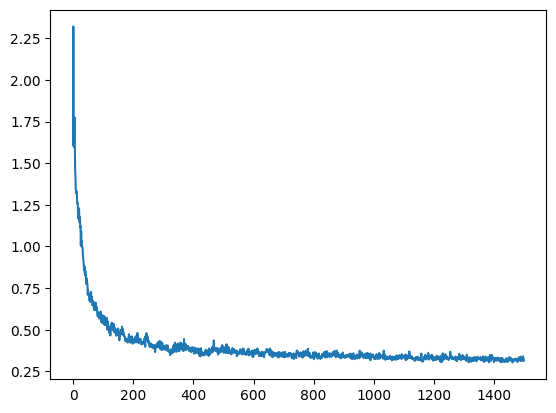

In [5]:
import matplotlib.pyplot as plt

plt.plot(wo_loss_list)

In [6]:
print('After Training, have a look at fitted kernel parameters...\n')

print('model covar_module_X output_scale\n', wo_my_model.covar_module_X.outputscale.data)
print('model covar_module_X base kernel lengthscale\n', wo_my_model.covar_module_X.base_kernel.lengthscale.data)
print('model covar_module_C outputscale\n', wo_my_model.covar_module_C.outputscale.data)
print('model covar_module_C base_kernel lengthscale\n', wo_my_model.covar_module_C.base_kernel.lengthscale.data)
print('likelihood noise_covar noise', wo_likelihood.noise_covar.noise.data)

After Training, have a look at fitted kernel parameters...

model covar_module_X output_scale
 tensor(0.8207)
model covar_module_X base kernel lengthscale
 tensor([[1.1719, 0.9635]])
model covar_module_C outputscale
 tensor(0.8207)
model covar_module_C base_kernel lengthscale
 tensor([[0.9501]])
likelihood noise_covar noise tensor([0.0001])


## Testing

In [7]:
# prediction output for all grid (total) inputs.
wo_my_model.eval()

batch_size_X = wo_n_outputs
batch_size_C = wo_n_C_total # this number must equal to n_total = 700 !
sample_X = wo_my_model.X.q_mu # TODO: try other meaningful approaches

# indices for all inputs.
batch_index_X = np.array([[i]*batch_size_C for i in range(batch_size_X)]).reshape(-1).tolist() 
batch_index_C = [i for i in range(batch_size_C)] * batch_size_X 

assert len(batch_index_X) == len(batch_index_C)

sample_batch_X = sample_X[batch_index_X]
sample_batch_C = wo_C_total[batch_index_C]
# NOTE: predictions for all inputs. 
wo_grid_output_batch = wo_my_model(sample_batch_X, sample_batch_C) # q(f)

### Train/Test RMSE

In [8]:
wo_train_data_predict = wo_grid_output_batch.loc.detach()[wo_sample_train_index]
train_rmse = (wo_train_data_predict - wo_sample_train_data).square().mean().sqrt()
print('Train RMSE', train_rmse)

wo_test_data_predict = wo_grid_output_batch.loc.detach()[wo_sample_test_index]
test_rmse = (wo_test_data_predict - wo_sample_test_data).square().mean().sqrt()
print('Test RMSE', test_rmse)

Train RMSE tensor(0.2358)
Test RMSE tensor(0.3189)


### Visual Inspect

In [22]:
# Pick the index of the funtion to show
wo_function_index = 14 # 0 - 19 (in total 20 output functions)

wo_train_input = wo_C_total[wo_train_C_tidily_indices]
wo_train_start = wo_train_input.shape[0] * wo_function_index
wo_train_end = wo_train_start + wo_train_input.shape[0]
wo_train_target = wo_sample_train_data[wo_train_start:wo_train_end]

wo_test_input = wo_C_total[wo_test_C_tidily_indices]
wo_test_start = wo_test_input.shape[0] * wo_function_index
wo_test_end = wo_test_start + wo_test_input.shape[0]
wo_test_target = wo_sample_test_data[wo_test_start:wo_test_end]

wo_gp_input = wo_C_total
wo_gp_start = wo_gp_input.shape[0] * wo_function_index
wo_gp_end = wo_gp_start + wo_gp_input.shape[0]
wo_gp_target = wo_sample_total_data[wo_gp_start:wo_gp_end]

wo_gp_pred_mean = wo_grid_output_batch.loc.detach()[wo_gp_start:wo_gp_end]
wo_gp_pred_std = wo_grid_output_batch.stddev.detach()[wo_gp_start:wo_gp_end]

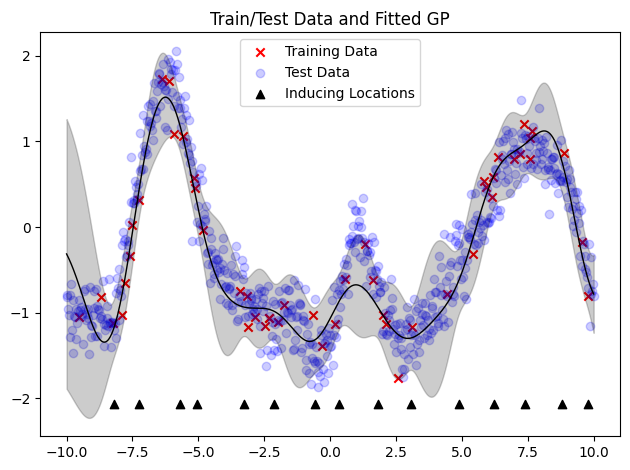

In [23]:
plot_traindata_testdata_fittedgp(train_X=wo_train_input, train_Y=wo_train_target, test_X=wo_test_input, test_Y=wo_test_target, gp_X=wo_gp_input, gp_pred_mean=wo_gp_pred_mean, gp_pred_std=wo_gp_pred_std, inducing_points_X=wo_my_model.variational_strategy.inducing_points_C.detach(), n_inducing_C=wo_n_inducing_C) # NOTE: input is C not X

### True v.s. Fitted latent variables

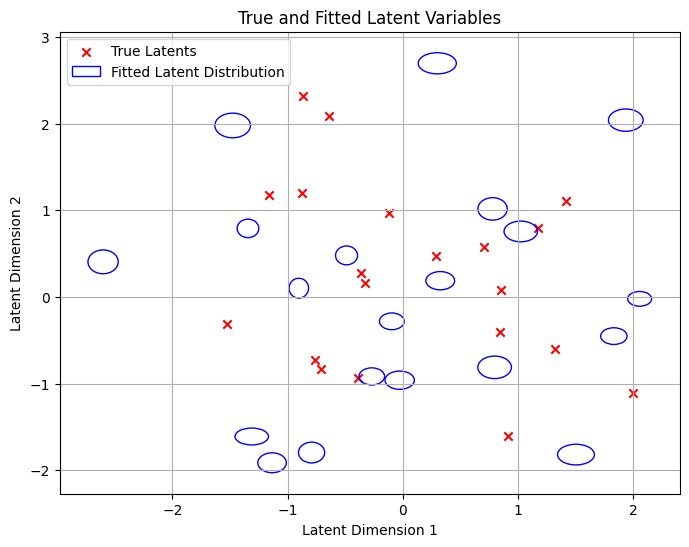

In [11]:
plot_true_and_fitted_latent(wo_X_true, wo_my_model.X.q_mu.detach(), torch.nn.functional.softplus(wo_my_model.X.q_log_sigma.detach()))

# With Missing data

### Load in data first

In [12]:
# This section is same as 'no missing data' case.
w_n_C_total = 700 # totally 700 points for C
w_n_outputs = 20
w_X_true, w_C_total, w_sample_total_data = tidily_sythetic_data_from_MOGP(n_C=w_n_C_total, n_X=w_n_outputs)

w_n_C_train = 50 # the number of training data points per output
w_n_C_test = w_n_C_total - w_n_C_train

# different from the previous case, C_train and C_test no longer a single set, but every output has different values.
w_ls_of_ls_train_C = []
w_ls_of_ls_test_C = []

w_sample_train_index, w_sample_test_index = [], []

for i in range(w_n_outputs):
    # iterate across different output functions
    train_index = random.sample(range(w_n_C_total), w_n_C_train)
    test_index = [index for index in range(w_n_C_total) if index not in train_index]
    w_ls_of_ls_train_C.append(train_index)
    w_ls_of_ls_test_C.append(test_index)
    '''
    C_train = C_total[train_index]
    C_test = C_total[test_index]
    assert C_train.shape[0] == n_train
    assert C_test.shape[0] == n_test
    C_train_List.append(C_train)
    C_test_List.append(C_test)
    '''
    w_sample_train_index = np.concatenate((w_sample_train_index, list(np.array(train_index) + w_n_C_total*i)))
    w_sample_test_index = np.concatenate((w_sample_test_index, list(np.array(test_index) + w_n_C_total*i)))

w_sample_train_data = w_sample_total_data[w_sample_train_index]
w_sample_test_data = w_sample_total_data[w_sample_test_index]

assert w_sample_train_data.shape[0] == w_n_C_train * w_n_outputs
assert w_sample_test_data.shape[0] == w_n_C_test * w_n_outputs


In [13]:
from util_functions import sample_index_X_and_C_from_list
# define hyper-parameters
w_n_X = w_X_true.shape[0]
w_n_C = len(w_ls_of_ls_train_C[0])
w_n_total = w_n_X * w_n_C
w_index_dim = 1
w_latent_dim = 2
w_n_inducing_C = 15
w_n_inducing_X = 30
w_pca = False

Y_train = w_sample_train_data

# specify model
w_my_model = LVMOGP_SVI(w_n_X, w_n_C, w_index_dim, w_latent_dim, w_n_inducing_C, w_n_inducing_X, Y_train.reshape(w_n_X, -1), pca=w_pca)

# Likelihood & training objective
w_likelihood = GaussianLikelihood()
w_mll = VariationalELBO(w_likelihood, w_my_model, num_data=w_n_total)

# load in partially-trained model
load_model = False
load_likelihood = False
if load_model:
    model_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/models/model_weights.pth'
    state_dict = torch.load(model_path)
    w_my_model.load_state_dict(state_dict)

if load_likelihood:
    likelihood_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/models/likelihood_weights.pth'
    state_dict = torch.load(likelihood_path)
    w_likelihood.load_state_dict(state_dict)

# optimizer and scheduler
w_optimizer = torch.optim.Adam([
    {'params': w_my_model.parameters()},
    {'params': w_likelihood.parameters()} 
], lr=0.3)

w_scheduler = StepLR(w_optimizer, step_size=50, gamma=0.95)  # every 50 iterations，learning rate multiple 0.95

# have a look at parameters
for name, param in w_my_model.named_parameters():
    print(name, param.size())

print('---' * 15) 
for name, param in w_likelihood.named_parameters():
    print(name, param.size())

# Initialize inducing points in C space
w_my_model.variational_strategy.inducing_points_C.data = torch.rand(wo_n_inducing_C).reshape(-1,1) * 20 - 10
# This depends on interval (-10,10) appear in tidily_sythetic_data_from_MOGP

# start training!
w_loss_list = []
n_iterations = 1500 # 10000
iterator = trange(n_iterations, leave=True)
batch_size_X = 20
batch_size_C = 50
w_model_max_grad_norm = 15
w_likeli_max_grad_norm = 0.7

w_my_model.train()
for i in iterator: 
    batch_index_X, batch_index_C = sample_index_X_and_C_from_list(w_ls_of_ls_train_C, batch_size_X=batch_size_X, batch_size_C=batch_size_C)
    # core code is here 
    w_optimizer.zero_grad()
    sample_X = w_my_model.sample_latent_variable()  # a full sample returns latent x across all n_X TODO: more efficient?
    sample_batch_X = sample_X[batch_index_X]
    sample_batch_C = w_C_total[batch_index_C]
    output_batch = w_my_model(sample_batch_X, sample_batch_C) # q(f)
    batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, w_n_X, w_n_C_total)
    loss = -w_mll(output_batch, w_sample_total_data[batch_index_Y]).sum()
    w_loss_list.append(loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
    loss.backward()

    # Clip gradients
    torch.nn.utils.clip_grad_norm_(w_my_model.parameters(), w_model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(w_likelihood.parameters(), w_likeli_max_grad_norm)

    w_optimizer.step()
    w_scheduler.step()

variational_strategy.inducing_points_X torch.Size([30, 2])
variational_strategy.inducing_points_C torch.Size([15, 1])
variational_strategy._variational_distribution.variational_mean torch.Size([450])
variational_strategy._variational_distribution.chol_variational_covar_X torch.Size([30, 30])
variational_strategy._variational_distribution.chol_variational_covar_C torch.Size([15, 15])
X.q_mu torch.Size([20, 2])
X.q_log_sigma torch.Size([20, 2])
covar_module_X.raw_outputscale torch.Size([])
covar_module_X.base_kernel.raw_lengthscale torch.Size([1, 2])
covar_module_C.raw_outputscale torch.Size([])
covar_module_C.base_kernel.raw_lengthscale torch.Size([1, 1])
---------------------------------------------
noise_covar.raw_noise torch.Size([1])


Loss: 0.329, iter no: 1499: 100%|██████████| 1500/1500 [03:06<00:00,  8.03it/s]


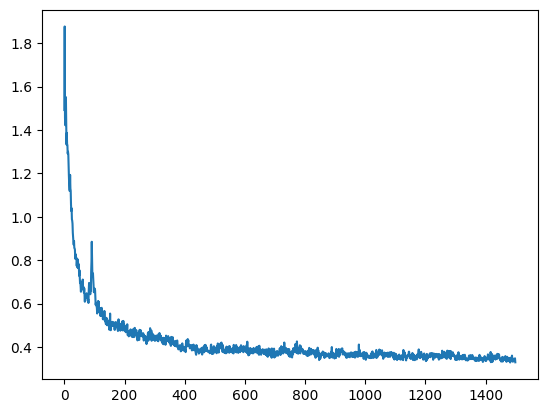

In [14]:
import matplotlib.pyplot as plt

plt.plot(w_loss_list)

## Testing

In [15]:
# prediction output for grid (total) inputs.
w_my_model.eval()

batch_size_X = 20
batch_size_C = 700 # this number must equal to n_total = 700 !
sample_X = w_my_model.X.q_mu # TODO: try other meaningful approaches

batch_index_X = np.array([[i]*batch_size_C for i in range(batch_size_X)]).reshape(-1).tolist() 
batch_index_C = [i for i in range(batch_size_C)] * batch_size_X 

assert len(batch_index_X) == len(batch_index_C)

sample_batch_X = sample_X[batch_index_X]
sample_batch_C = w_C_total[batch_index_C]
w_grid_output_batch = w_my_model(sample_batch_X, sample_batch_C) # q(f)

### Train/Test data RMSE

In [16]:
w_train_data_predict = w_grid_output_batch.loc.detach()[w_sample_train_index]
train_rmse = (w_train_data_predict - w_sample_train_data).square().mean().sqrt()
print('Train RMSE', train_rmse)

w_test_data_predict = w_grid_output_batch.loc.detach()[w_sample_test_index]
test_rmse = (w_test_data_predict - w_sample_test_data).square().mean().sqrt()
print('Test RMSE', test_rmse)

Train RMSE tensor(0.2629)
Test RMSE tensor(0.3230)


### Visual Inspect

In [24]:
# Pick the index of the funtion to show
w_function_index = 3 # 0 - 19 (in total 20 output functions)

w_train_input = w_C_total[w_ls_of_ls_train_C[w_function_index]]
w_train_start = 0
for i in range(w_function_index):
    w_train_start += len(w_ls_of_ls_train_C[i])
w_train_end = w_train_start + len(w_ls_of_ls_train_C[w_function_index])
w_train_target = w_sample_train_data[w_train_start:w_train_end]


w_test_input = w_C_total[w_ls_of_ls_test_C[w_function_index]]
w_test_start = 0
for j in range(w_function_index):
    w_test_start += len(w_ls_of_ls_test_C[i])
w_test_end = w_test_start + len(w_ls_of_ls_test_C[w_function_index])
w_test_target = w_sample_test_data[w_test_start:w_test_end]


w_gp_input = w_C_total
w_gp_start = w_gp_input.shape[0] * w_function_index
w_gp_end = w_gp_start + w_gp_input.shape[0]
w_gp_target = w_sample_total_data[w_gp_start:w_gp_end]

w_gp_pred_mean = w_grid_output_batch.loc.detach()[w_gp_start:w_gp_end]
w_gp_pred_std = w_grid_output_batch.stddev.detach()[w_gp_start:w_gp_end]

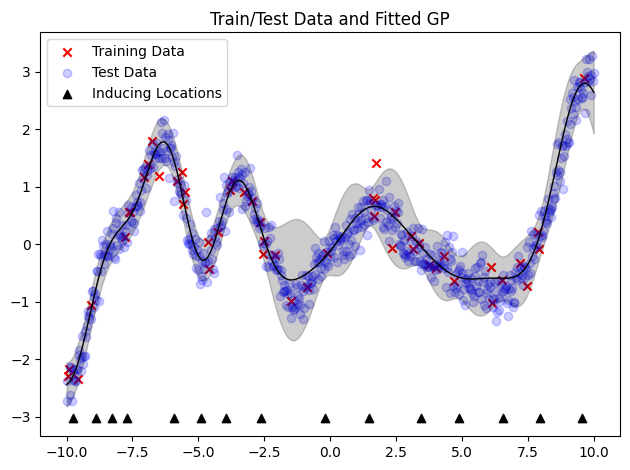

In [25]:
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=w_gp_input, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=w_my_model.variational_strategy.inducing_points_C.detach()) # NOTE: input is C not X

### True v.s. Fitted latent variables

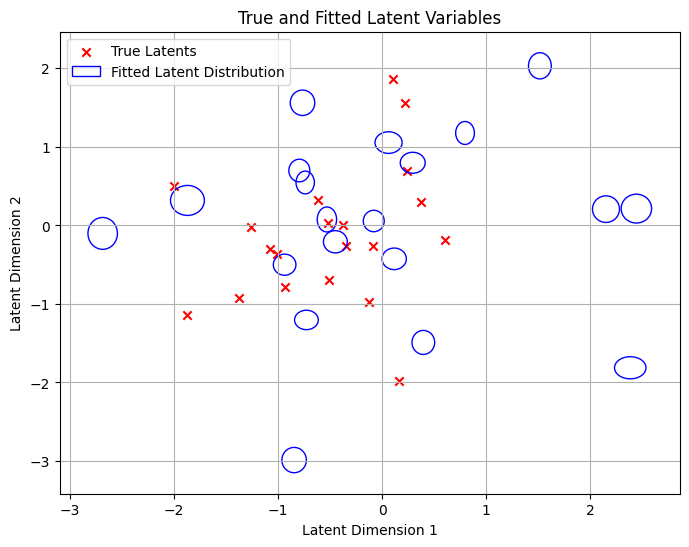

In [19]:
plot_true_and_fitted_latent(w_X_true, w_my_model.X.q_mu.detach(), torch.nn.functional.softplus(w_my_model.X.q_log_sigma.detach()))